# Converting shapefiles (.shp) to gridded/rastered NetCDF (.nc) 
*by Hagen Radtke, 2020-06-25*

## Read in the shapefile

The shapefile is saved in the subfolder `my_folder`. It consists of several files with different file extensions.
We will read it using the R library `rgdal`.

In [1]:
setwd("/silos/notebook_collection/converting_files/shapefile_nc_raster/")
library("rgdal")
shape = rgdal::readOGR("my_folder","IPCC_regions_Aug2013")

Loading required package: sp
rgdal: version: 1.5-10, (SVN revision 1006)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.3.3, released 2018/12/14
Path to GDAL shared files: /silos/conda_packages/radtke/miniconda3_4.8.2/OS_42.3/conda_env/iow_python/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 5.2.0, September 15th, 2018, [PJ_VERSION: 520]
Path to PROJ shared files: /sw/data/python/miniconda3/4.8.2/OS_42.3/envs/iow_r_basic/share/proj
Linking to sp version:1.3-1


OGR data source with driver: ESRI Shapefile 
Source: "/silos/notebook_collection/converting_files/shapefile_nc_raster/my_folder", layer: "IPCC_regions_Aug2013"
with 18 features
It has 2 fields


Check if the shape is already on a latitude-longitude grid:

In [3]:
shape@proj4string

CRS arguments: +proj=longlat +ellps=clrk66 +no_defs 

Okay, projection is already "longlat". If this is not the case, we have to reproject it like this:

``projection <- "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0" ``

``shape <- spTransform(shape, CRS(projection))``

Load the `raster` package to define a regular grid and then rasterize the shapefile to get a matrix

In [8]:
library("raster")
# define latitude-longitude range and resolution
ext <- extent(-30, 50, 30, 75)
gridresolution <- 0.5

r <- raster(ext, res=gridresolution)

## Rasterize the shapefile
rr <- rasterize(shape, r)
mymatrix <- as.matrix(rr)


We can plot the matrix

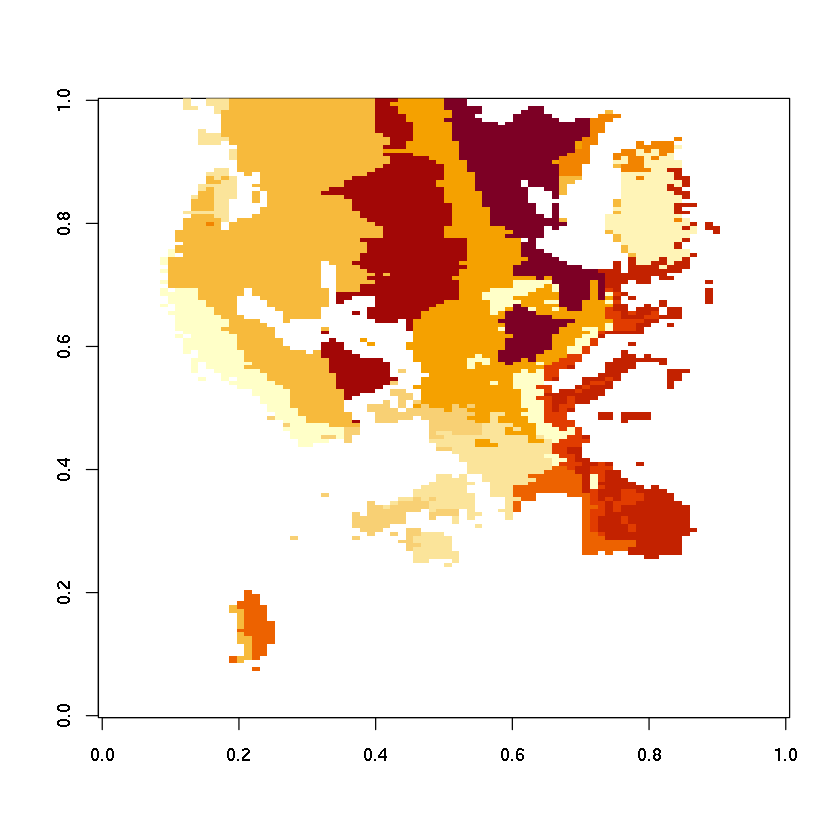

In [10]:
image(mymatrix)

It seems that latitude is the second axis so we need to transpose the matrix before plotting

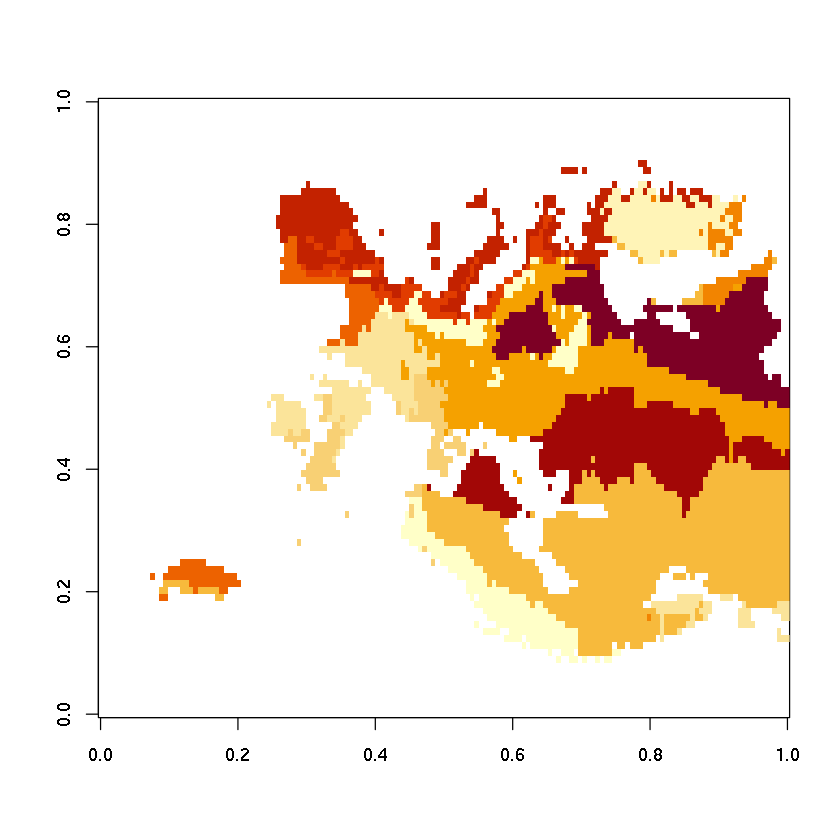

In [11]:
image(t(mymatrix))

Still not good: Latitude is in decreasing order. We need to reverse the first axis (keep the second one):

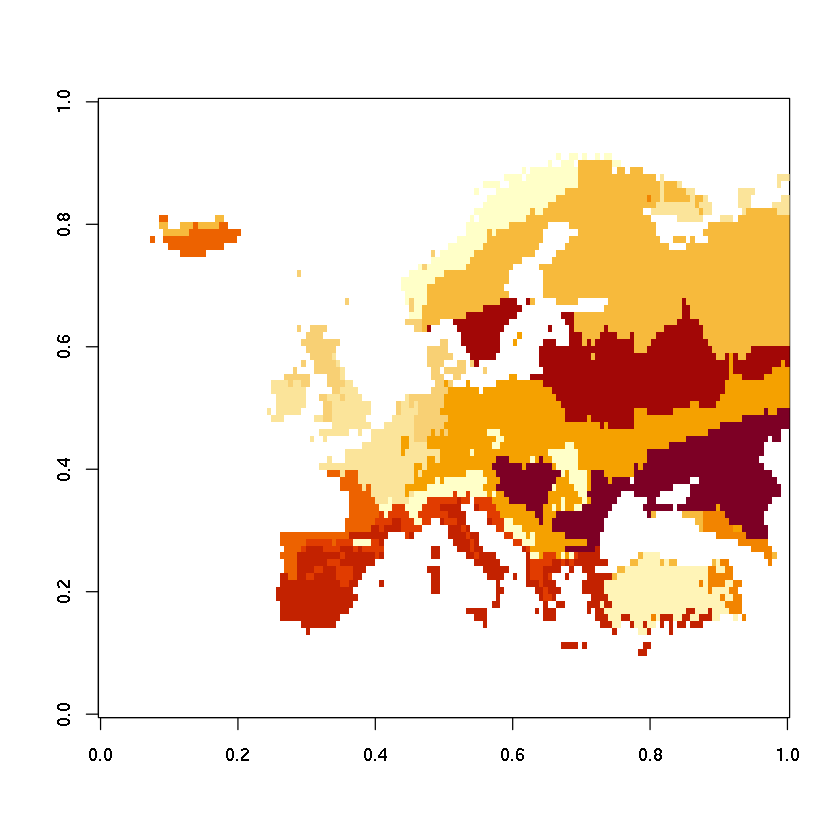

In [12]:
final_matrix = apply(mymatrix,2,rev)
image(t(final_matrix))

That looks good but what do the values mean? We can find it out.

In [12]:
legend = shape@data
legend

,IPCC17,IPCC5
0,Alpine North,Alpine
1,Alpine South,Alpine
2,Anatolian,Southern
3,Arctic,Northern
4,Atlantic Central,Atlantic
5,Atlantic North,Atlantic
6,Black Sea,Southern
7,Boreal,Northern
8,Continental,Continental
9,Eastern Mountains,Alpine


Now load the NetCDF library and create an output file

In [7]:
library("RNetCDF")
# create NetCDF file
nc = create.nc("gridded.nc")

But we need to define the coordinate axes first before writing the data

In [8]:
latitude = seq(from=3,by=gridresolution,length.out = dim(final_matrix)[1])
longitude = seq(from=-30,by=gridresolution,length.out = dim(final_matrix)[2])

Now we write the axes first and then the data and close the file

In [9]:
# write axes
dim.def.nc(nc,"xaxis",length(longitude))
var.def.nc(nc,"xaxis","NC_DOUBLE",c("xaxis"))
var.put.nc(nc,"xaxis",longitude)
att.put.nc(nc,"xaxis","units","NC_CHAR","degrees_east")
att.put.nc(nc,"xaxis","cartesian_axis","NC_CHAR","x")

dim.def.nc(nc,"yaxis",length(latitude))
var.def.nc(nc,"yaxis","NC_DOUBLE",c("yaxis"))
var.put.nc(nc,"yaxis",latitude)
att.put.nc(nc,"yaxis","units","NC_CHAR","degrees_north")
att.put.nc(nc,"yaxis","cartesian_axis","NC_CHAR","y")

# write data
var.def.nc(nc,"climate_region","NC_DOUBLE",c("yaxis","xaxis"))
var.put.nc(nc, "climate_region", mymatrix)

# close NetCDF file
close.nc(nc)

Check if that worked by running a system command:

In [10]:
system("ncdump -h gridded.nc", intern=TRUE )

[1] "netcdf gridded {"                       
 [2] "dimensions:"                            
 [3] "\txaxis = 160 ;"                        
 [4] "\tyaxis = 90 ;"                         
 [5] "variables:"                             
 [6] "\tdouble xaxis(xaxis) ;"                
 [7] "\t\txaxis:units = \"degrees_east\" ;"   
 [8] "\t\txaxis:cartesian_axis = \"x\" ;"     
 [9] "\tdouble yaxis(yaxis) ;"                
[10] "\t\tyaxis:units = \"degrees_north\" ;"  
[11] "\t\tyaxis:cartesian_axis = \"y\" ;"     
[12] "\tdouble climate_region(xaxis, yaxis) ;"
[13] "}"

In [11]:
# more nicely formatted:
cat(paste(system("ncdump -h gridded.nc", intern=TRUE ),'\n'))

netcdf gridded { 
 dimensions: 
 	xaxis = 160 ; 
 	yaxis = 90 ; 
 variables: 
 	double xaxis(xaxis) ; 
 		xaxis:units = "degrees_east" ; 
 		xaxis:cartesian_axis = "x" ; 
 	double yaxis(yaxis) ; 
 		yaxis:units = "degrees_north" ; 
 		yaxis:cartesian_axis = "y" ; 
 	double climate_region(xaxis, yaxis) ; 
 } 
